<a href="https://colab.research.google.com/github/VladislavEpifanow/BoysNextDoor/blob/main/Predictive_analytics%2C_Methods_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [2]:
import json

In [4]:
with open("test-dataset.json","r") as read_file:
  data = json.load(read_file)

In [5]:
data

{'NavStartMin': '2019-12-31',
 'SeriesName': ['T3(°C)'],
 'SeriesData': [[None,
   None,
   None,
   None,
   None,
   68.5,
   68.6,
   68.9,
   68.6,
   68.3,
   68.6,
   68.6,
   68.0,
   67.6,
   68.3,
   67.8,
   68.6,
   68.7,
   68.3,
   68.3,
   67.9,
   68.3,
   68.1,
   68.9,
   69.2,
   68.6,
   68.5,
   68.1,
   68.8,
   68.4,
   68.5,
   68.2,
   68.4,
   68.5,
   69.0,
   68.2,
   68.4,
   68.3,
   68.5,
   68.2,
   68.0,
   68.5,
   68.7,
   68.7,
   67.6,
   67.6,
   69.0,
   68.8,
   68.1,
   66.6,
   66.0,
   65.8,
   66.0,
   65.8,
   65.3,
   65.4,
   65.8,
   65.9,
   66.0,
   66.1,
   66.0,
   66.3,
   66.8,
   67.1,
   67.1,
   67.1,
   66.7,
   66.5,
   66.2,
   65.6,
   65.9,
   66.3,
   66.8,
   67.5,
   66.2,
   63.9,
   63.9,
   63.7,
   63.7,
   63.9,
   64.0,
   64.5,
   65.4,
   65.6,
   64.8,
   63.7,
   63.6,
   64.0,
   64.5,
   64.6,
   63.9,
   63.9,
   64.2,
   64.5,
   64.1,
   63.2,
   63.3,
   63.6,
   63.9,
   63.9,
   63.9,
   63.9,
   63.9,
  

In [6]:
from datetime import datetime, timedelta

In [7]:
time_series = data['SeriesData'][0]

In [8]:
print("Всего {} измерений, из которых {} - пустых ".format(len(time_series),time_series.count(None)))
print("Процент пустых измерений составляет : {} %".format(time_series.count(None)/len(time_series)*100))

Всего 3010 измерений, из которых 542 - пустых 
Процент пустых измерений составляет : 18.006644518272424 %


In [9]:
print("Start date : {}, End date : {}".format(data['NavStart'],data['NavEnd']))

Start date : 2019-12-31, End date : 2021-08-05


In [10]:
start_date = datetime(*[int(x) for x in data['NavStart'].split('-')])

In [11]:
end_date = datetime(*[int(x) for x in data['NavEnd'].split('-')])

In [12]:
def get_timescales(start_date,end_date,ts_size):
  time_delta = (end_date - start_date)/ts_size
  return [start_date + time_delta*i for i in range(ts_size)]

In [13]:
datas = get_timescales(start_date,end_date,len(time_series))

In [14]:
from matplotlib.dates import DateFormatter

In [15]:
data['GraphName']

'Температура ГВC'

In [29]:
time_series = np.array(time_series)

In [28]:
time_series

array([64.5, 64.1, 64.2, ..., 53.9, 55.4, 52.7], dtype=object)

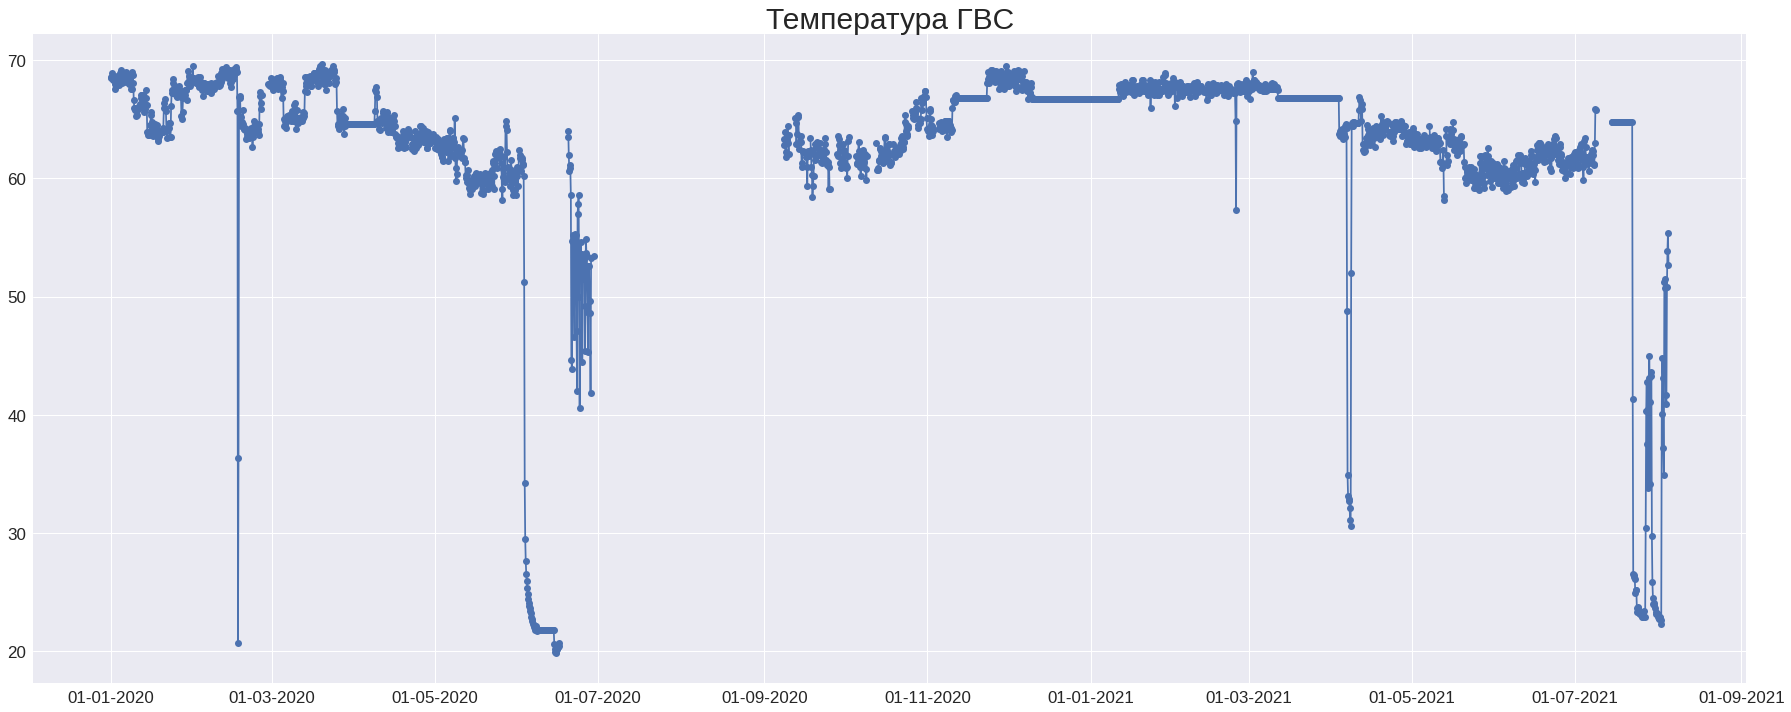

In [23]:
# Построение графика временного ряда 
plt.style.use('seaborn')
plt.figure(figsize=(25,10))
date_format = DateFormatter('%d-%m-%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.plot_date(datas, time_series,linestyle ='solid')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(data['GraphName'], fontdict = {'fontsize' : 30})
plt.tight_layout()
plt.show()

Как видно - 18 процентов данных являются пустыми - что не очень хорошо. Нужно решать, как избавиться от этого


Попробуем доставать только те данные, которые идут подряд без пропусков

In [31]:
len(time_series)

3010

In [108]:
def prepareTimeSeriesDataset(time_series,features):
  X = []
  y = []
  for i in range(0,len(time_series) - (features + 1)):
    if time_series[i:i + features - 1 ].all() and time_series[i+features] is not None:
      X.append(time_series[i:i + features - 1 ])
      y.append(time_series[i+features])
  return np.array(X), np.array(y)

In [304]:
X,y = prepareTimeSeriesDataset(time_series,25)

In [305]:
from sklearn.linear_model import ElasticNet

In [306]:
from sklearn.model_selection import train_test_split

In [307]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [308]:
regr = ElasticNet()
regr.fit(X_train,y_train)
print("Средняя квадратичная ошибка составляет: {}".format(mean_squared_error(y_test,regr.predict(X_test))))

Средняя квадратичная ошибка составляет: 7.436307321219975


In [309]:
for i in range(X_train.shape[0]):
  for j in range(X_train.shape[1]):
    if X_train[i,j] is None:
      print(i,j)
      

In [310]:
time_series[-14:]

array([40.1, 44.8, 43.1, 37.2, 34.9, 51.2, 50.7, 51.5, 41.7, 40.9, 50.8,
       53.9, 55.4, 52.7], dtype=object)

In [311]:
def make_time_series_prediction(model,future_points,time_series,n_features,start_time,time_interval):
  predicted_time_series = []
  predicted_dates = []
  for i in time_series[-n_features:]:
    predicted_time_series.append(i)
  for j in range(future_points):
    predicted_time_series.append(model.predict(np.array(predicted_time_series[j:j+n_features]).reshape(1, -1))[0])
  for it in range(len(predicted_time_series)):
    predicted_dates.append(start_time + it*time_interval)
  return predicted_time_series, predicted_dates


In [296]:
regr.predict(X_test[-1].reshape(1,-1))[0]

60.18690014526736

In [297]:
time_series[-6:]

array([41.7, 40.9, 50.8, 53.9, 55.4, 52.7], dtype=object)

In [313]:
time_series[-600:-(600-24)]

array([64.7, 64.7, 65.8, 66.9, 66.6, 66.0, 64.9, 65.9, 66.3, 62.9, 62.4,
       62.2, 62.4, 62.3, 62.7, 63.4, 62.9, 63.1, 64.5, 64.2, 63.7, 63.4,
       63.5, 62.8], dtype=object)

In [314]:
start_time = datas[-600]

In [315]:
start_time

datetime.datetime(2021, 4, 10, 18, 53, 49, 235400)

In [316]:
time_interval = datas[-99] - datas[-100]

In [317]:
predictions, pred_dates = make_time_series_prediction(regr,1200,time_series[-600:-(600-24)],24,start_time,time_interval)

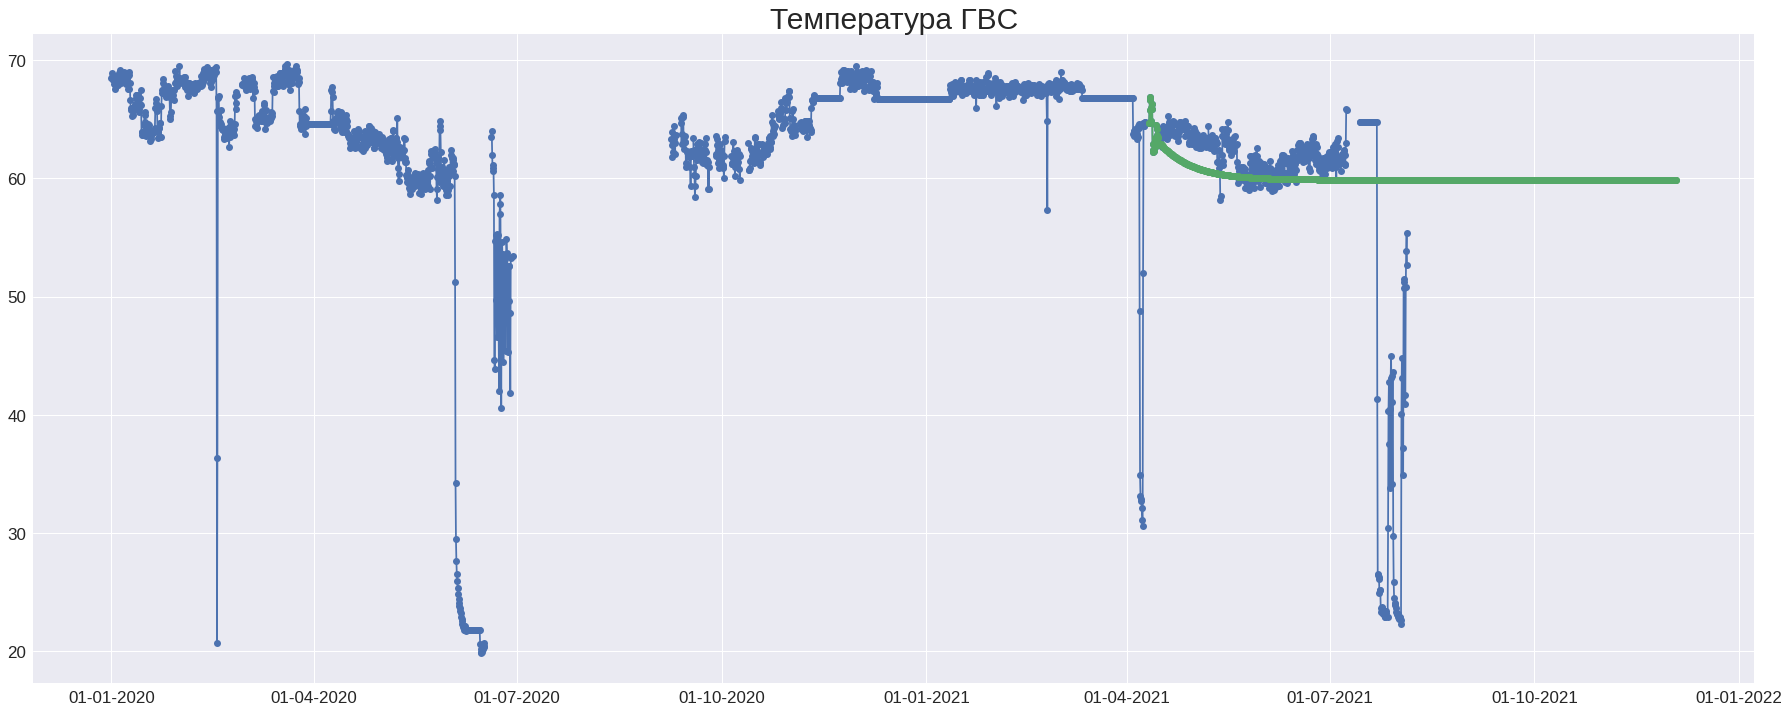

In [318]:
# Построение графика временного ряда 
plt.style.use('seaborn')
plt.figure(figsize=(25,10))
date_format = DateFormatter('%d-%m-%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.plot_date(datas, time_series,linestyle ='solid')
plt.plot_date(pred_dates, predictions,linestyle ='solid')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(data['GraphName'], fontdict = {'fontsize' : 30})
plt.tight_layout()
plt.show()

In [321]:
y.mean()

63.12808398950131

Пока что получается, что прогноз стремиться к какому то одному значение( чет типа среднего)

Предлагаемые следующие действия:
1.   Прогон моделей на искусственных данных без пропусков
2.   Добавление разных типов моделей, а именно: Статистические, нейронные сети
3.   Замена пропусков
